# Validation & Inference (5-fold curves, evaluation, final model)

Function:
1. **Learning curve**：Record Train/Val MSE for each fold and draw (early stop).
2. **Evaluation visualization**：fully combined Pred vs True, error histogram, calibration curve.
3. **Finish model (full quantity)**：Train in the best configuration (Hybrid + Clip-level + Gender & log(Duration)) and score 2–3 samples.

In [17]:

import os, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
TEXT_DIM = 768

BASE = '/Users/susie/Desktop/Multimodal analysis of disagreement/disagreement-dataset'
NPZ  = os.path.join(BASE, 'Embedding', 'dataset_T20.npz')
META = os.path.join(BASE, 'metadata.csv')

MODEL_DIR = '/Users/susie/Desktop/Multimodal analysis of disagreement/Models'
os.makedirs(MODEL_DIR, exist_ok=True)
MODEL_PATH = os.path.join(MODEL_DIR, 'hybrid_clip_gender_duration.pt')

if not os.path.exists(NPZ):
    raise FileNotFoundError(f'No feature set found：{NPZ}')
if not os.path.exists(META):
    raise FileNotFoundError(f'No metadata found：{META}')

data = np.load(NPZ, allow_pickle=True)
X_all = data['X'].astype('float32')
y_all = data['y'].astype('float32')
clips = data['clips']
L_all = (np.abs(X_all).sum(axis=2) > 0).sum(axis=1).astype('int64')

meta = pd.read_csv(META, encoding='latin-1')
key  = 'File name' if 'File name' in meta.columns else 'File_name'
fold_col = [c for c in meta.columns if c.lower() in ('fold','cv','kfold')][0]
meta_df = meta.set_index(key).loc[clips]
folds = meta_df[fold_col].values

print('Loaded:', X_all.shape, y_all.shape, len(clips))
print('Model will be saved to:', MODEL_PATH)


Loaded: (684, 20, 1792) (684,) 684
Model will be saved to: /Users/susie/Desktop/Multimodal analysis of disagreement/Models/hybrid_clip_gender_duration.pt


In [18]:

def build_meta_gender_duration(df_subset: pd.DataFrame):
    df = df_subset[['Gender','Duration']].copy()
    df['Duration'] = np.log1p(df['Duration'].astype(float))
    ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    gender_ohe = ohe.fit_transform(df[['Gender']])
    scaler = StandardScaler()
    dur_std = scaler.fit_transform(df[['Duration']].values)
    M = np.concatenate([gender_ohe, dur_std], axis=1).astype('float32')
    return M, ohe, scaler

M_all, OHE_GENDER, SCALER_DUR = build_meta_gender_duration(meta_df)
M_all.shape


(684, 4)

In [19]:

class BiLSTMBlock(nn.Module):
    def __init__(self, d_in, hidden=128, layers=1, bidir=True, dropout=0.1):
        super().__init__()
        self.lstm = nn.LSTM(d_in, hidden, num_layers=layers, batch_first=True,
                            bidirectional=bidir, dropout=dropout if layers>1 else 0.0)
        self.bidir = bidir; self.hidden = hidden
    @property
    def out_dim(self):
        return self.hidden * (2 if self.bidir else 1)
    def forward(self, x, lens):
        pack = nn.utils.rnn.pack_padded_sequence(x, lens.cpu(), batch_first=True, enforce_sorted=False)
        out, (h, _) = self.lstm(pack)
        out, _ = nn.utils.rnn.pad_packed_sequence(out, batch_first=True, total_length=x.size(1))
        h_last = torch.cat([h[-2], h[-1]], dim=1) if self.bidir else h[-1]
        return out, h_last

class HybridWithMetaClip(nn.Module):
    def __init__(self, d_txt, d_aud, m_in, hidden=256, layers=1, bidir=True, dropout=0.1):
        super().__init__()
        h_half = max(1, hidden // 2)
        self.txt_branch = BiLSTMBlock(d_txt, hidden=h_half, layers=layers, bidir=bidir, dropout=dropout)
        self.aud_branch = BiLSTMBlock(d_aud, hidden=h_half, layers=layers, bidir=bidir, dropout=dropout)
        self.fusion = BiLSTMBlock(self.txt_branch.out_dim + self.aud_branch.out_dim,
                                  hidden=hidden, layers=layers, bidir=bidir, dropout=dropout)
        self.norm_txt = nn.LayerNorm(d_txt)
        self.norm_aud = nn.LayerNorm(d_aud)
        self.head = nn.Sequential(nn.Linear(self.fusion.out_dim + m_in, 128),
                                  nn.ReLU(), nn.Dropout(0.2), nn.Linear(128,1))
    def forward(self, x, lens, m):
        x_txt = self.norm_txt(x[:, :, :TEXT_DIM])
        x_aud = self.norm_aud(x[:, :, TEXT_DIM:])
        seq_t, _ = self.txt_branch(x_txt, lens)
        seq_a, _ = self.aud_branch(x_aud, lens)
        fused_seq = torch.cat([seq_t, seq_a], dim=-1)
        _, h = self.fusion(fused_seq, lens)
        z = torch.cat([h, m], dim=1)
        return self.head(z).squeeze(-1)


## 1) Learning curve

In [ ]:

from sklearn.metrics import mean_squared_error
all_hist = {}
EPOCHS = 40
BATCH = 64
LR = 3e-4
PATIENCE = 5

for k in sorted(np.unique(folds)):
    te_idx = np.where(folds==k)[0]
    tr_idx = np.where(folds!=k)[0]

    Xtr = torch.tensor(X_all[tr_idx]); ytr = torch.tensor(y_all[tr_idx])
    Ltr = torch.tensor(L_all[tr_idx]); Mtr = torch.tensor(M_all[tr_idx])
    Xte = torch.tensor(X_all[te_idx]); yte = torch.tensor(y_all[te_idx])
    Lte = torch.tensor(L_all[te_idx]); Mte = torch.tensor(M_all[te_idx])

    d_txt = TEXT_DIM; d_aud = X_all.shape[2] - d_txt; m_in = M_all.shape[1]
    model = HybridWithMetaClip(d_txt=d_txt, d_aud=d_aud, m_in=m_in).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
    lossf = nn.MSELoss()

    tr_loader = DataLoader(TensorDataset(Xtr, ytr, Ltr, Mtr), batch_size=BATCH, shuffle=True)
    te_loader = DataLoader(TensorDataset(Xte, yte, Lte, Mte), batch_size=BATCH, shuffle=False)

    hist_train, hist_val = [], []
    best = float('inf'); wait = 0

    for ep in range(1, EPOCHS+1):
        model.train(); batch_losses = []
        for xb, yb, lb, mb in tr_loader:
            xb, yb, lb, mb = xb.to(DEVICE), yb.to(DEVICE), lb.to(DEVICE), mb.to(DEVICE)
            pred = model(xb, lb, mb)
            loss = lossf(pred, yb); opt.zero_grad(); loss.backward(); opt.step()
            batch_losses.append(loss.item())
        tr_mse = float(np.mean(batch_losses))

        model.eval(); P, T = [], []
        with torch.no_grad():
            for xb, yb, lb, mb in te_loader:
                p = model(xb.to(DEVICE), lb.to(DEVICE), mb.to(DEVICE)).cpu().numpy()
                P.append(p); T.append(yb.numpy())
        val_mse = mean_squared_error(np.concatenate(T), np.concatenate(P))

        hist_train.append(tr_mse); hist_val.append(val_mse)

        if val_mse + 1e-6 < best: best, wait = val_mse, 0
        else:
            wait += 1
            if wait >= PATIENCE: break

    all_hist[int(k)] = {'train':hist_train, 'val':hist_val, 'best':best, 'stop_ep':len(hist_train)}

for k in sorted(all_hist.keys()):
    hist = all_hist[k]
    plt.figure(figsize=(6,4))
    plt.plot(range(1,len(hist['train'])+1), hist['train'], label='Train MSE')
    plt.plot(range(1,len(hist['val'])+1), hist['val'], label='Val MSE')
    plt.xlabel('Epoch'); plt.ylabel('MSE')
    plt.title(f'Learning Curve (Fold={k}) | stop={hist["stop_ep"]}, best_val={hist["best"]:.3f}')
    plt.legend(); plt.show()


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

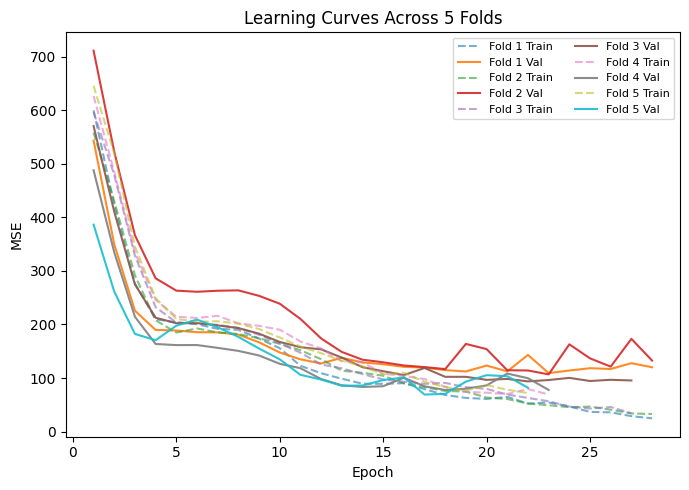

In [ ]:
plt.figure(figsize=(7,5))

for k in sorted(all_hist.keys()):
    hist = all_hist[k]
    plt.plot(
        range(1, len(hist['train'])+1),
        hist['train'],
        linestyle='--', alpha=0.6,
        label=f'Fold {k} Train'
    )
    plt.plot(
        range(1, len(hist['val'])+1),
        hist['val'],
        alpha=0.9,
        label=f'Fold {k} Val'
    )

plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('Learning Curves Across 5 Folds')
plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()

## 2) Fully combined evaluation graph (scatter/Error histogram/calibration curve)

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

Saved predictions to: /Users/susie/Desktop/Multimodal analysis of disagreement/Figures&Graphs/cv_preds_hybrid_clip_gender_duration.csv
Overall CCC = 0.715
Metrics: {'RMSE': 9.643271801626202, 'MAE': 7.33195686340332, 'R2': 0.5508719177968111, 'r': 0.7430646612632827, 'p': 0.0, 'CCC_optional': 0.715093039996826}


findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

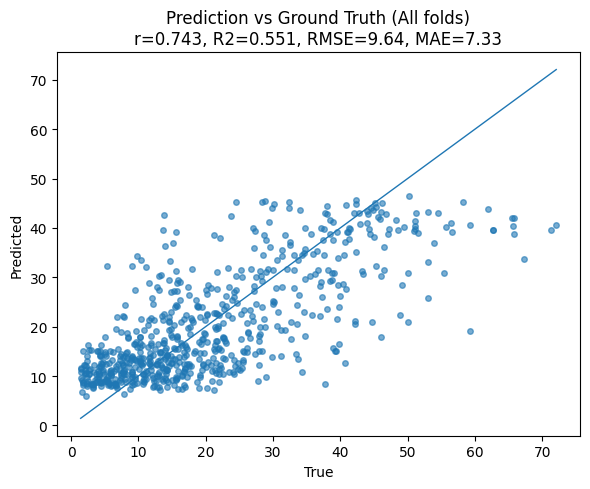

findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not

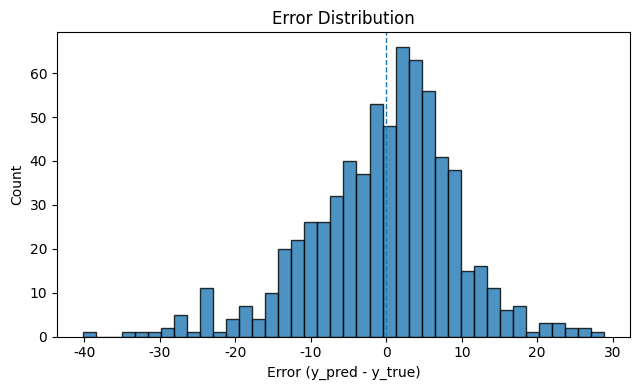

/var/folders/57/htbxy0cn4mvg1gf4vj6__md40000gn/T/ipykernel_15484/862733641.py:144: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cal = dfc.groupby('bin')[['y_true','y_pred']].mean()
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not found.
findfont: Font family 'SimHei' not fou

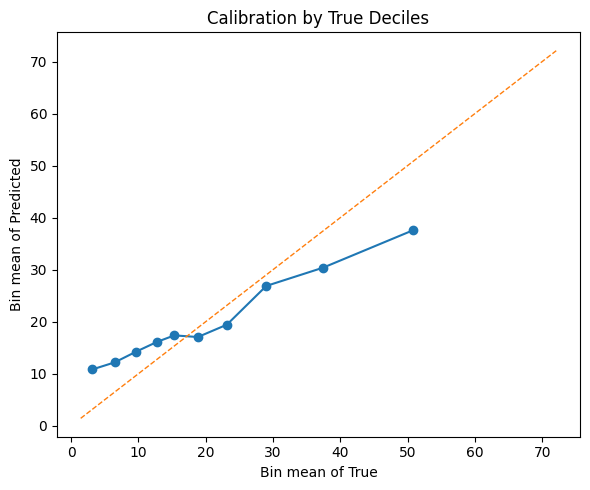

In [ ]:
# === Reproduction experiment settings: 40 rounds + early stop, fixed random seeds, collect each fold prediction and merge evaluation ===
import os, json, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from scipy import stats

# 1) Seed
SEED = 2025
import random
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 2) Training settings
EPOCHS   = 40
BATCH    = 64
LR       = 3e-4
PATIENCE = 5  # early stop patience

# 3) Pearson r + p， CCC
def pearson_r_p(y, yhat):
    r, p = stats.pearsonr(y, yhat)
    return float(r), float(p)

def ccc(y, yhat):
    y = np.asarray(y); yhat = np.asarray(yhat)
    mu1, mu2 = y.mean(), yhat.mean()
    s1, s2   = y.var(ddof=1), yhat.var(ddof=1)
    cov      = np.cov(y, yhat, ddof=1)[0,1]
    return float((2*cov) / (s1 + s2 + (mu1 - mu2)**2 + 1e-12))

# 4) Fold training + stop early, collect predictions
all_rows = []
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
save_dir = os.path.join(os.path.dirname(BASE), 'Figures&Graphs')
os.makedirs(save_dir, exist_ok=True)

for k in sorted(np.unique(folds)):
    te_idx = np.where(folds==k)[0]
    tr_idx = np.where(folds!=k)[0]

    Xtr = torch.tensor(X_all[tr_idx]); ytr = torch.tensor(y_all[tr_idx])
    Ltr = torch.tensor(L_all[tr_idx]); Mtr = torch.tensor(M_all[tr_idx])
    Xte = torch.tensor(X_all[te_idx]); yte = torch.tensor(y_all[te_idx])
    Lte = torch.tensor(L_all[te_idx]); Mte = torch.tensor(M_all[te_idx])

    d_txt = TEXT_DIM; d_aud = X_all.shape[2] - d_txt; m_in = M_all.shape[1]
    model = HybridWithMetaClip(d_txt=d_txt, d_aud=d_aud, m_in=m_in).to(DEVICE)

    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
    lossf = nn.MSELoss()
    tr_loader = DataLoader(TensorDataset(Xtr, ytr, Ltr, Mtr), batch_size=BATCH, shuffle=True)
    te_loader = DataLoader(TensorDataset(Xte, yte, Lte, Mte), batch_size=BATCH, shuffle=False)

    best = np.inf; wait = 0
    best_state = None

    for ep in range(1, EPOCHS+1):
        model.train()
        for xb, yb, lb, mb in tr_loader:
            xb, yb, lb, mb = xb.to(DEVICE), yb.to(DEVICE), lb.to(DEVICE), mb.to(DEVICE)
            pred = model(xb, lb, mb)
            loss = lossf(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()

        # MSE
        model.eval(); P, T = [], []
        with torch.no_grad():
            for xb, yb, lb, mb in te_loader:
                p = model(xb.to(DEVICE), lb.to(DEVICE), mb.to(DEVICE)).cpu().numpy()
                P.append(p); T.append(yb.numpy())
        preds = np.concatenate(P); trues = np.concatenate(T)
        val_mse = mean_squared_error(trues, preds)

        # Early stop
        if val_mse + 1e-6 < best:
            best = val_mse; wait = 0
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
        else:
            wait += 1
            if wait >= PATIENCE:
                break

    # Roll back to optimal
    if best_state is not None:
        model.load_state_dict(best_state)

    # Re-run the prediction with the best model
    model.eval(); P, T = [], []
    with torch.no_grad():
        for xb, yb, lb, mb in te_loader:
            p = model(xb.to(DEVICE), lb.to(DEVICE), mb.to(DEVICE)).cpu().numpy()
            P.append(p); T.append(yb.numpy())
    preds = np.concatenate(P); trues = np.concatenate(T)
    all_rows.append(pd.DataFrame({'clip':clips[te_idx], 'y_true':trues, 'y_pred':preds, 'fold':k}))

# 5) Evaluation
pred_df = pd.concat(all_rows, ignore_index=True)
pred_path = os.path.join(save_dir, 'cv_preds_hybrid_clip_gender_duration.csv')
pred_df.to_csv(pred_path, index=False)
print('Saved predictions to:', pred_path)

mse  = float(np.mean((pred_df['y_true']-pred_df['y_pred'])**2))
rmse = float(np.sqrt(mse))
mae  = float(np.mean(np.abs(pred_df['y_true']-pred_df['y_pred'])))
r, p = pearson_r_p(pred_df['y_true'], pred_df['y_pred'])
r2   = float(r2_score(pred_df['y_true'], pred_df['y_pred']))
cccv = ccc(pred_df['y_true'], pred_df['y_pred'])
print(f'Overall CCC = {cccv:.3f}')

metrics = {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'r': r, 'p': p, 'CCC_optional': cccv}
with open(os.path.join(save_dir, 'cv_metrics_hybrid_clip_gender_duration.json'),'w') as f:
    json.dump(metrics, f, indent=2)
print('Metrics:', metrics)


# 6) Visualizations
plt.figure(figsize=(6,5))
plt.scatter(pred_df['y_true'], pred_df['y_pred'], alpha=0.6, s=16)
mn, mx = pred_df['y_true'].min(), pred_df['y_true'].max()
plt.plot([mn,mx],[mn,mx], linewidth=1)
plt.xlabel('True'); plt.ylabel('Predicted')
plt.title(f'Prediction vs Ground Truth (All folds)\nr={r:.3f}, R2={r2:.3f}, RMSE={rmse:.2f}, MAE={mae:.2f}')
plt.tight_layout()
plt.savefig(os.path.join(save_dir,'cv_scatter.png'), dpi=300)
plt.show()

err = pred_df['y_pred'] - pred_df['y_true']
plt.figure(figsize=(6.5,4))
plt.hist(err, bins=40, edgecolor='k', alpha=0.8)
plt.axvline(0, linestyle='--', linewidth=1)
plt.xlabel('Error (y_pred - y_true)'); plt.ylabel('Count')
plt.title('Error Distribution')
plt.tight_layout()
plt.savefig(os.path.join(save_dir,'cv_err_hist.png'), dpi=300)
plt.show()

# 校准曲线（按 true 分位）
dfc = pred_df.copy()
dfc['bin'] = pd.qcut(dfc['y_true'], 10, duplicates='drop')
cal = dfc.groupby('bin')[['y_true','y_pred']].mean()
plt.figure(figsize=(6,5))
plt.plot(cal['y_true'].values, cal['y_pred'].values, marker='o')
plt.plot([mn,mx],[mn,mx], linestyle='--', linewidth=1)
plt.xlabel('Bin mean of True'); plt.ylabel('Bin mean of Predicted')
plt.title('Calibration by True Deciles')
plt.tight_layout()
plt.savefig(os.path.join(save_dir,'cv_calibration.png'), dpi=300)
plt.show()


## 3) Train the final model (full) and score 2–3 samples

In [ ]:

def _prep_meta_for_infer(gender: str, duration_sec: float):
    g_vec = OHE_GENDER.transform(pd.DataFrame({'Gender':[gender]})[['Gender']])
    d_log = np.log1p([[float(duration_sec)]])
    d_std = SCALER_DUR.transform(d_log)
    M = np.concatenate([g_vec, d_std], axis=1).astype('float32')
    return M

class FinalWrapper(nn.Module):
    def __init__(self, d_txt, d_aud, m_in):
        super().__init__()
        self.net = HybridWithMetaClip(d_txt=d_txt, d_aud=d_aud, m_in=m_in)
    def forward(self, x, l, m):
        return self.net(x, l, m)

def train_full_model(epochs=40, batch=64, lr=3e-4):
    d_txt = TEXT_DIM; d_aud = X_all.shape[2] - d_txt; m_in  = M_all.shape[1]
    model = FinalWrapper(d_txt, d_aud, m_in).to(DEVICE)
    dl = DataLoader(TensorDataset(torch.tensor(X_all), torch.tensor(y_all),
                                  torch.tensor(L_all), torch.tensor(M_all)),
                    batch_size=batch, shuffle=True)
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    lossf = nn.MSELoss()
    model.train()
    for ep in range(epochs):
        for xb, yb, lb, mb in dl:
            xb, yb, lb, mb = xb.to(DEVICE), yb.to(DEVICE), lb.to(DEVICE), mb.to(DEVICE)
            pred = model(xb, lb, mb)
            loss = lossf(pred, yb)
            opt.zero_grad(); loss.backward(); opt.step()
    torch.save({'state_dict': model.state_dict()}, MODEL_PATH)
    print('Saved:', MODEL_PATH)

def load_model_for_infer():
    d_txt = TEXT_DIM; d_aud = X_all.shape[2] - d_txt
    m_in = _prep_meta_for_infer('FF', 30.0).shape[1]
    model = FinalWrapper(d_txt, d_aud, m_in).to(DEVICE)
    ckpt = torch.load(MODEL_PATH, map_location=DEVICE)
    model.load_state_dict(ckpt['state_dict'])
    model.eval()
    return model

def predict_for_clip_id(clip_id: str):
    idx = np.where(clips == clip_id)[0]
    if len(idx)==0:
        raise ValueError('clip_id not found: ' + str(clip_id))
    i = int(idx[0])
    model = load_model_for_infer()
    M = _prep_meta_for_infer(meta_df.iloc[i]['Gender'], float(meta_df.iloc[i]['Duration']))
    with torch.no_grad():
        x = torch.tensor(X_all[i:i+1]).to(DEVICE)
        l = torch.tensor(L_all[i:i+1]).to(DEVICE)
        m = torch.tensor(M).to(DEVICE)
        yhat = model(x, l, m).cpu().numpy()[0]
    return float(yhat)

def predict_from_array(X_seq: np.ndarray, gender: str, duration_sec: float):
    if X_seq.ndim != 2:
        raise ValueError('X_seq must be 2D array of shape (T, D)')
    model = load_model_for_infer()
    M = _prep_meta_for_infer(gender, float(duration_sec))
    L = np.array([(np.abs(X_seq).sum(axis=1) > 0).sum()], dtype='int64')
    with torch.no_grad():
        x = torch.tensor(X_seq[None].astype('float32')).to(DEVICE)
        l = torch.tensor(L).to(DEVICE)
        m = torch.tensor(M).to(DEVICE)
        yhat = model(x, l, m).cpu().numpy()[0]
    return float(yhat)

print("train_full_model(), predict_for_clip_id(), predict_from_array()")


函数就绪：train_full_model(), predict_for_clip_id(), predict_from_array()


In [ ]:
train_full_model(epochs=40, batch=64, lr=3e-4)

模型已保存: /Users/susie/Desktop/Multimodal analysis of disagreement/Models/hybrid_clip_gender_duration.pt


In [ ]:
print('Ex1:', clips[0], predict_for_clip_id(clips[0]))
print('Ex2:', clips[1], predict_for_clip_id(clips[1]))
print('Ex3:', clips[2], predict_for_clip_id(clips[2]))

Ex1: F01_10 32.044586181640625
Ex2: F01_11 10.1782865524292
Ex3: F01_12 10.918122291564941


/var/folders/57/htbxy0cn4mvg1gf4vj6__md40000gn/T/ipykernel_15484/2239112140.py:37: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(MODEL_PATH, map_location=D